# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=150  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.25), kernel_size=1, stride=1, padding=0, bias=False)
        
        #------------------------ 另一半 ----------------------------
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.75), one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        # w=w[0]
        w=torch.randn(w[0].shape).cuda()*0.1
        a=torch.randn(1).cuda()*0.1
        if a>0.39:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel//2,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel//2,in_Channel]
        
        #-------------------------------------
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        
        if a>0.39:
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [ ]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%5==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.304061, Accuracy: 9.77
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.372634, Accuracy: 9.38
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.316781, Accuracy: 10.55
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.298085, Accuracy: 12.11
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.266056, Accuracy: 14.06
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.239116, Accuracy: 19.14
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.189332, Accuracy: 21.09
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.210619, Accuracy: 16.41
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.240159, Accuracy: 14.06
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.212480, Accuracy: 16.02
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.199320, Accuracy: 16.41
Train Epoch: 0 [14080/50000 (31%)]	Loss: 2.220272, Accuracy: 19.14
Train Epoch: 0 [15360/50000 (34%)]	Loss: 2.130681, Accuracy: 19.92
Train Epoch: 0 [16640/50000 (37%)]	Loss: 2.148274, Accuracy: 18.75
Train Epoch: 0 [17920/50000 (40%)]	Loss: 2.172867, Accuracy: 19.53
Train Epoch:

Train Epoch: 2 [3840/50000 (9%)]	Loss: 1.593053, Accuracy: 39.45
Train Epoch: 2 [5120/50000 (11%)]	Loss: 1.672608, Accuracy: 30.86
Train Epoch: 2 [6400/50000 (14%)]	Loss: 1.730368, Accuracy: 30.47
Train Epoch: 2 [7680/50000 (17%)]	Loss: 1.631249, Accuracy: 35.94
Train Epoch: 2 [8960/50000 (20%)]	Loss: 1.837130, Accuracy: 30.47
Train Epoch: 2 [10240/50000 (23%)]	Loss: 1.760695, Accuracy: 32.42
Train Epoch: 2 [11520/50000 (26%)]	Loss: 1.584890, Accuracy: 36.72
Train Epoch: 2 [12800/50000 (28%)]	Loss: 1.707246, Accuracy: 32.03
Train Epoch: 2 [14080/50000 (31%)]	Loss: 1.523630, Accuracy: 40.23
Train Epoch: 2 [15360/50000 (34%)]	Loss: 1.626100, Accuracy: 36.33
Train Epoch: 2 [16640/50000 (37%)]	Loss: 1.558649, Accuracy: 32.03
Train Epoch: 2 [17920/50000 (40%)]	Loss: 1.578175, Accuracy: 35.55
Train Epoch: 2 [19200/50000 (43%)]	Loss: 1.617920, Accuracy: 38.67
Train Epoch: 2 [20480/50000 (45%)]	Loss: 1.613811, Accuracy: 40.62
Train Epoch: 2 [21760/50000 (48%)]	Loss: 1.481089, Accuracy: 39.45
T

Train Epoch: 5 [16640/50000 (37%)]	Loss: 1.041009, Accuracy: 59.38
Train Epoch: 5 [17920/50000 (40%)]	Loss: 0.835472, Accuracy: 71.48
Train Epoch: 5 [19200/50000 (43%)]	Loss: 1.040945, Accuracy: 67.97
Train Epoch: 5 [20480/50000 (45%)]	Loss: 0.871164, Accuracy: 64.84
Train Epoch: 5 [21760/50000 (48%)]	Loss: 1.009804, Accuracy: 65.23
Train Epoch: 5 [23040/50000 (51%)]	Loss: 1.013122, Accuracy: 62.89
Train Epoch: 5 [24320/50000 (54%)]	Loss: 0.980042, Accuracy: 63.28
Train Epoch: 5 [25600/50000 (57%)]	Loss: 1.004642, Accuracy: 61.72
Train Epoch: 5 [26880/50000 (60%)]	Loss: 1.055038, Accuracy: 64.06
Train Epoch: 5 [28160/50000 (62%)]	Loss: 0.928549, Accuracy: 66.41
Train Epoch: 5 [29440/50000 (65%)]	Loss: 0.936967, Accuracy: 62.89
Train Epoch: 5 [30720/50000 (68%)]	Loss: 0.929007, Accuracy: 66.41
Train Epoch: 5 [32000/50000 (71%)]	Loss: 1.044582, Accuracy: 64.06
Train Epoch: 5 [33280/50000 (74%)]	Loss: 0.924809, Accuracy: 65.62
Train Epoch: 5 [34560/50000 (77%)]	Loss: 0.879304, Accuracy: 6

Train Epoch: 8 [29440/50000 (65%)]	Loss: 0.746013, Accuracy: 74.22
Train Epoch: 8 [30720/50000 (68%)]	Loss: 0.634548, Accuracy: 76.95
Train Epoch: 8 [32000/50000 (71%)]	Loss: 0.614052, Accuracy: 77.73
Train Epoch: 8 [33280/50000 (74%)]	Loss: 0.622135, Accuracy: 80.08
Train Epoch: 8 [34560/50000 (77%)]	Loss: 0.610054, Accuracy: 79.30
Train Epoch: 8 [35840/50000 (80%)]	Loss: 0.619737, Accuracy: 76.56
Train Epoch: 8 [37120/50000 (82%)]	Loss: 0.746299, Accuracy: 72.66
Train Epoch: 8 [38400/50000 (85%)]	Loss: 0.596119, Accuracy: 80.86
Train Epoch: 8 [39680/50000 (88%)]	Loss: 0.586286, Accuracy: 80.08
Train Epoch: 8 [40960/50000 (91%)]	Loss: 0.726054, Accuracy: 74.61
Train Epoch: 8 [42240/50000 (94%)]	Loss: 0.640899, Accuracy: 79.69
Train Epoch: 8 [43520/50000 (97%)]	Loss: 0.628793, Accuracy: 78.12
Train Epoch: 8 [35000/50000 (99%)]	Loss: 0.697187, Accuracy: 79.50

Validation set: Average loss: 0.9486, Accuracy: 3477/5000 (69.00%)

the time of this epoch:[35.33906435966492 s]
Train Epoch: 9 

Train Epoch: 11 [39680/50000 (88%)]	Loss: 0.610155, Accuracy: 78.12
Train Epoch: 11 [40960/50000 (91%)]	Loss: 0.592909, Accuracy: 78.52
Train Epoch: 11 [42240/50000 (94%)]	Loss: 0.663524, Accuracy: 76.56
Train Epoch: 11 [43520/50000 (97%)]	Loss: 0.492802, Accuracy: 83.59
Train Epoch: 11 [35000/50000 (99%)]	Loss: 0.543284, Accuracy: 81.00

Validation set: Average loss: 0.6642, Accuracy: 3875/5000 (77.00%)

the time of this epoch:[38.437947511672974 s]
Train Epoch: 12 [0/50000 (0%)]	Loss: 0.529178, Accuracy: 79.69
Train Epoch: 12 [1280/50000 (3%)]	Loss: 0.475553, Accuracy: 85.94
Train Epoch: 12 [2560/50000 (6%)]	Loss: 0.567437, Accuracy: 81.25
Train Epoch: 12 [3840/50000 (9%)]	Loss: 0.588094, Accuracy: 83.20
Train Epoch: 12 [5120/50000 (11%)]	Loss: 0.636053, Accuracy: 77.73
Train Epoch: 12 [6400/50000 (14%)]	Loss: 0.446368, Accuracy: 85.94
Train Epoch: 12 [7680/50000 (17%)]	Loss: 0.637187, Accuracy: 82.03
Train Epoch: 12 [8960/50000 (20%)]	Loss: 0.519570, Accuracy: 80.08
Train Epoch: 12 

Train Epoch: 15 [2560/50000 (6%)]	Loss: 0.450236, Accuracy: 85.16
Train Epoch: 15 [3840/50000 (9%)]	Loss: 0.442820, Accuracy: 86.33
Train Epoch: 15 [5120/50000 (11%)]	Loss: 0.440344, Accuracy: 83.98
Train Epoch: 15 [6400/50000 (14%)]	Loss: 0.490121, Accuracy: 85.55
Train Epoch: 15 [7680/50000 (17%)]	Loss: 0.397810, Accuracy: 85.94
Train Epoch: 15 [8960/50000 (20%)]	Loss: 0.579301, Accuracy: 80.08
Train Epoch: 15 [10240/50000 (23%)]	Loss: 0.544597, Accuracy: 79.69
Train Epoch: 15 [11520/50000 (26%)]	Loss: 0.547140, Accuracy: 80.86
Train Epoch: 15 [12800/50000 (28%)]	Loss: 0.594435, Accuracy: 80.86
Train Epoch: 15 [14080/50000 (31%)]	Loss: 0.507586, Accuracy: 83.98
Train Epoch: 15 [15360/50000 (34%)]	Loss: 0.429429, Accuracy: 86.72
Train Epoch: 15 [16640/50000 (37%)]	Loss: 0.562704, Accuracy: 80.86
Train Epoch: 15 [17920/50000 (40%)]	Loss: 0.480632, Accuracy: 84.38
Train Epoch: 15 [19200/50000 (43%)]	Loss: 0.472525, Accuracy: 84.38
Train Epoch: 15 [20480/50000 (45%)]	Loss: 0.483638, Accu

Train Epoch: 17 [43520/50000 (97%)]	Loss: 0.393233, Accuracy: 85.94
Train Epoch: 17 [35000/50000 (99%)]	Loss: 0.471052, Accuracy: 86.50

Validation set: Average loss: 0.9033, Accuracy: 3521/5000 (70.00%)

the time of this epoch:[35.26086950302124 s]
Train Epoch: 18 [0/50000 (0%)]	Loss: 0.323610, Accuracy: 91.02
Train Epoch: 18 [1280/50000 (3%)]	Loss: 0.510394, Accuracy: 82.42
Train Epoch: 18 [2560/50000 (6%)]	Loss: 0.459993, Accuracy: 86.72
Train Epoch: 18 [3840/50000 (9%)]	Loss: 0.444287, Accuracy: 82.42
Train Epoch: 18 [5120/50000 (11%)]	Loss: 0.505314, Accuracy: 82.81
Train Epoch: 18 [6400/50000 (14%)]	Loss: 0.388403, Accuracy: 85.94
Train Epoch: 18 [7680/50000 (17%)]	Loss: 0.303466, Accuracy: 92.19
Train Epoch: 18 [8960/50000 (20%)]	Loss: 0.464084, Accuracy: 83.98
Train Epoch: 18 [10240/50000 (23%)]	Loss: 0.447420, Accuracy: 85.16
Train Epoch: 18 [11520/50000 (26%)]	Loss: 0.487951, Accuracy: 84.38
Train Epoch: 18 [12800/50000 (28%)]	Loss: 0.481379, Accuracy: 83.59
Train Epoch: 18 [

Train Epoch: 21 [5120/50000 (11%)]	Loss: 0.401403, Accuracy: 86.72
Train Epoch: 21 [6400/50000 (14%)]	Loss: 0.457828, Accuracy: 83.59
Train Epoch: 21 [7680/50000 (17%)]	Loss: 0.352693, Accuracy: 88.67
Train Epoch: 21 [8960/50000 (20%)]	Loss: 0.400258, Accuracy: 85.16
Train Epoch: 21 [10240/50000 (23%)]	Loss: 0.407708, Accuracy: 85.94
Train Epoch: 21 [11520/50000 (26%)]	Loss: 0.373371, Accuracy: 87.89
Train Epoch: 21 [12800/50000 (28%)]	Loss: 0.555247, Accuracy: 80.86
Train Epoch: 21 [14080/50000 (31%)]	Loss: 0.480856, Accuracy: 83.59
Train Epoch: 21 [15360/50000 (34%)]	Loss: 0.437841, Accuracy: 85.16
Train Epoch: 21 [16640/50000 (37%)]	Loss: 0.493905, Accuracy: 83.59
Train Epoch: 21 [17920/50000 (40%)]	Loss: 0.508773, Accuracy: 83.20
Train Epoch: 21 [19200/50000 (43%)]	Loss: 0.420419, Accuracy: 87.50
Train Epoch: 21 [20480/50000 (45%)]	Loss: 0.586698, Accuracy: 80.47
Train Epoch: 21 [21760/50000 (48%)]	Loss: 0.448714, Accuracy: 86.33
Train Epoch: 21 [23040/50000 (51%)]	Loss: 0.387116, 

Train Epoch: 24 [1280/50000 (3%)]	Loss: 0.343780, Accuracy: 89.45
Train Epoch: 24 [2560/50000 (6%)]	Loss: 0.410944, Accuracy: 87.11
Train Epoch: 24 [3840/50000 (9%)]	Loss: 0.409101, Accuracy: 84.77
Train Epoch: 24 [5120/50000 (11%)]	Loss: 0.392207, Accuracy: 87.11
Train Epoch: 24 [6400/50000 (14%)]	Loss: 0.384289, Accuracy: 86.72
Train Epoch: 24 [7680/50000 (17%)]	Loss: 0.469846, Accuracy: 83.59
Train Epoch: 24 [8960/50000 (20%)]	Loss: 0.454216, Accuracy: 85.94
Train Epoch: 24 [10240/50000 (23%)]	Loss: 0.384355, Accuracy: 86.72
Train Epoch: 24 [11520/50000 (26%)]	Loss: 0.437048, Accuracy: 87.11
Train Epoch: 24 [12800/50000 (28%)]	Loss: 0.522100, Accuracy: 82.42
Train Epoch: 24 [14080/50000 (31%)]	Loss: 0.402666, Accuracy: 86.33
Train Epoch: 24 [15360/50000 (34%)]	Loss: 0.398148, Accuracy: 86.33
Train Epoch: 24 [16640/50000 (37%)]	Loss: 0.437743, Accuracy: 86.72
Train Epoch: 24 [17920/50000 (40%)]	Loss: 0.394834, Accuracy: 86.72
Train Epoch: 24 [19200/50000 (43%)]	Loss: 0.520781, Accura

Train Epoch: 27 [11520/50000 (26%)]	Loss: 0.344391, Accuracy: 87.11
Train Epoch: 27 [12800/50000 (28%)]	Loss: 0.264544, Accuracy: 89.84
Train Epoch: 27 [14080/50000 (31%)]	Loss: 0.461384, Accuracy: 85.94
Train Epoch: 27 [15360/50000 (34%)]	Loss: 0.381571, Accuracy: 88.28
Train Epoch: 27 [16640/50000 (37%)]	Loss: 0.376666, Accuracy: 87.11
Train Epoch: 27 [17920/50000 (40%)]	Loss: 0.361180, Accuracy: 86.33
Train Epoch: 27 [19200/50000 (43%)]	Loss: 0.416237, Accuracy: 83.98
Train Epoch: 27 [20480/50000 (45%)]	Loss: 0.410487, Accuracy: 85.94
Train Epoch: 27 [21760/50000 (48%)]	Loss: 0.429046, Accuracy: 86.33
Train Epoch: 27 [23040/50000 (51%)]	Loss: 0.383941, Accuracy: 86.72
Train Epoch: 27 [24320/50000 (54%)]	Loss: 0.542141, Accuracy: 82.81
Train Epoch: 27 [25600/50000 (57%)]	Loss: 0.397885, Accuracy: 86.33
Train Epoch: 27 [26880/50000 (60%)]	Loss: 0.469584, Accuracy: 84.77
Train Epoch: 27 [28160/50000 (62%)]	Loss: 0.470085, Accuracy: 85.55
Train Epoch: 27 [29440/50000 (65%)]	Loss: 0.3709

Train Epoch: 30 [23040/50000 (51%)]	Loss: 0.353229, Accuracy: 87.11
Train Epoch: 30 [24320/50000 (54%)]	Loss: 0.417723, Accuracy: 88.28
Train Epoch: 30 [25600/50000 (57%)]	Loss: 0.548482, Accuracy: 83.98
Train Epoch: 30 [26880/50000 (60%)]	Loss: 0.437927, Accuracy: 87.11
Train Epoch: 30 [28160/50000 (62%)]	Loss: 0.392212, Accuracy: 87.89
Train Epoch: 30 [29440/50000 (65%)]	Loss: 0.434010, Accuracy: 85.94
Train Epoch: 30 [30720/50000 (68%)]	Loss: 0.328087, Accuracy: 87.11
Train Epoch: 30 [32000/50000 (71%)]	Loss: 0.439506, Accuracy: 84.38
Train Epoch: 30 [33280/50000 (74%)]	Loss: 0.472958, Accuracy: 83.59
Train Epoch: 30 [34560/50000 (77%)]	Loss: 0.452483, Accuracy: 82.81
Train Epoch: 30 [35840/50000 (80%)]	Loss: 0.335593, Accuracy: 86.72
Train Epoch: 30 [37120/50000 (82%)]	Loss: 0.494433, Accuracy: 82.42
Train Epoch: 30 [38400/50000 (85%)]	Loss: 0.319398, Accuracy: 90.23
Train Epoch: 30 [39680/50000 (88%)]	Loss: 0.387985, Accuracy: 85.55
Train Epoch: 30 [40960/50000 (91%)]	Loss: 0.3859

Train Epoch: 33 [25600/50000 (57%)]	Loss: 0.455601, Accuracy: 86.33
Train Epoch: 33 [26880/50000 (60%)]	Loss: 0.457291, Accuracy: 82.81
Train Epoch: 33 [28160/50000 (62%)]	Loss: 0.298327, Accuracy: 89.84
Train Epoch: 33 [29440/50000 (65%)]	Loss: 0.343745, Accuracy: 90.23
Train Epoch: 33 [30720/50000 (68%)]	Loss: 0.463402, Accuracy: 86.33
Train Epoch: 33 [32000/50000 (71%)]	Loss: 0.413879, Accuracy: 85.55
Train Epoch: 33 [33280/50000 (74%)]	Loss: 0.408151, Accuracy: 86.33
Train Epoch: 33 [34560/50000 (77%)]	Loss: 0.369474, Accuracy: 87.50
Train Epoch: 33 [35840/50000 (80%)]	Loss: 0.391777, Accuracy: 87.50
Train Epoch: 33 [37120/50000 (82%)]	Loss: 0.410670, Accuracy: 85.94
Train Epoch: 33 [38400/50000 (85%)]	Loss: 0.491790, Accuracy: 82.42
Train Epoch: 33 [39680/50000 (88%)]	Loss: 0.369537, Accuracy: 86.72
Train Epoch: 33 [40960/50000 (91%)]	Loss: 0.366206, Accuracy: 87.89
Train Epoch: 33 [42240/50000 (94%)]	Loss: 0.298599, Accuracy: 89.84
Train Epoch: 33 [43520/50000 (97%)]	Loss: 0.3304

Train Epoch: 36 [35840/50000 (80%)]	Loss: 0.406762, Accuracy: 87.50
Train Epoch: 36 [37120/50000 (82%)]	Loss: 0.427833, Accuracy: 87.50
Train Epoch: 36 [38400/50000 (85%)]	Loss: 0.446675, Accuracy: 83.20
Train Epoch: 36 [39680/50000 (88%)]	Loss: 0.434525, Accuracy: 85.16
Train Epoch: 36 [40960/50000 (91%)]	Loss: 0.436506, Accuracy: 83.98
Train Epoch: 36 [42240/50000 (94%)]	Loss: 0.456733, Accuracy: 84.38
Train Epoch: 36 [43520/50000 (97%)]	Loss: 0.376025, Accuracy: 85.16
Train Epoch: 36 [35000/50000 (99%)]	Loss: 0.431380, Accuracy: 86.50

Validation set: Average loss: 0.6185, Accuracy: 3988/5000 (79.00%)

the time of this epoch:[38.1513831615448 s]
Train Epoch: 37 [0/50000 (0%)]	Loss: 0.408842, Accuracy: 84.77
Train Epoch: 37 [1280/50000 (3%)]	Loss: 0.355622, Accuracy: 85.94
Train Epoch: 37 [2560/50000 (6%)]	Loss: 0.358382, Accuracy: 88.67
Train Epoch: 37 [3840/50000 (9%)]	Loss: 0.407388, Accuracy: 85.55
Train Epoch: 37 [5120/50000 (11%)]	Loss: 0.383861, Accuracy: 86.72
Train Epoch: 37

Train Epoch: 40 [1280/50000 (3%)]	Loss: 0.391593, Accuracy: 86.72
Train Epoch: 40 [2560/50000 (6%)]	Loss: 0.376223, Accuracy: 88.67
Train Epoch: 40 [3840/50000 (9%)]	Loss: 0.399735, Accuracy: 86.72
Train Epoch: 40 [5120/50000 (11%)]	Loss: 0.347019, Accuracy: 86.72
Train Epoch: 40 [6400/50000 (14%)]	Loss: 0.283393, Accuracy: 91.41
Train Epoch: 40 [7680/50000 (17%)]	Loss: 0.469097, Accuracy: 85.94
Train Epoch: 40 [8960/50000 (20%)]	Loss: 0.339416, Accuracy: 90.23
Train Epoch: 40 [10240/50000 (23%)]	Loss: 0.356741, Accuracy: 88.28
Train Epoch: 40 [11520/50000 (26%)]	Loss: 0.405572, Accuracy: 87.11
Train Epoch: 40 [12800/50000 (28%)]	Loss: 0.343045, Accuracy: 87.89
Train Epoch: 40 [14080/50000 (31%)]	Loss: 0.489683, Accuracy: 83.59
Train Epoch: 40 [15360/50000 (34%)]	Loss: 0.415947, Accuracy: 85.16
Train Epoch: 40 [16640/50000 (37%)]	Loss: 0.441405, Accuracy: 86.33
Train Epoch: 40 [17920/50000 (40%)]	Loss: 0.491715, Accuracy: 83.98
Train Epoch: 40 [19200/50000 (43%)]	Loss: 0.460032, Accura

Train Epoch: 43 [11520/50000 (26%)]	Loss: 0.422956, Accuracy: 85.55
Train Epoch: 43 [12800/50000 (28%)]	Loss: 0.349539, Accuracy: 87.11
Train Epoch: 43 [14080/50000 (31%)]	Loss: 0.288349, Accuracy: 91.80
Train Epoch: 43 [15360/50000 (34%)]	Loss: 0.388666, Accuracy: 86.33
Train Epoch: 43 [16640/50000 (37%)]	Loss: 0.476385, Accuracy: 85.16
Train Epoch: 43 [17920/50000 (40%)]	Loss: 0.417635, Accuracy: 84.38
Train Epoch: 43 [19200/50000 (43%)]	Loss: 0.369661, Accuracy: 87.11
Train Epoch: 43 [20480/50000 (45%)]	Loss: 0.413663, Accuracy: 88.28
Train Epoch: 43 [21760/50000 (48%)]	Loss: 0.379194, Accuracy: 86.72
Train Epoch: 43 [23040/50000 (51%)]	Loss: 0.426578, Accuracy: 85.94
Train Epoch: 43 [24320/50000 (54%)]	Loss: 0.361789, Accuracy: 88.28
Train Epoch: 43 [25600/50000 (57%)]	Loss: 0.348998, Accuracy: 88.67
Train Epoch: 43 [26880/50000 (60%)]	Loss: 0.361296, Accuracy: 87.89
Train Epoch: 43 [28160/50000 (62%)]	Loss: 0.342637, Accuracy: 90.23
Train Epoch: 43 [29440/50000 (65%)]	Loss: 0.3911

Train Epoch: 46 [21760/50000 (48%)]	Loss: 0.380068, Accuracy: 87.50
Train Epoch: 46 [23040/50000 (51%)]	Loss: 0.354764, Accuracy: 87.50
Train Epoch: 46 [24320/50000 (54%)]	Loss: 0.334967, Accuracy: 87.89
Train Epoch: 46 [25600/50000 (57%)]	Loss: 0.329230, Accuracy: 89.45
Train Epoch: 46 [26880/50000 (60%)]	Loss: 0.378624, Accuracy: 85.55
Train Epoch: 46 [28160/50000 (62%)]	Loss: 0.479010, Accuracy: 83.59
Train Epoch: 46 [29440/50000 (65%)]	Loss: 0.331172, Accuracy: 88.28
Train Epoch: 46 [30720/50000 (68%)]	Loss: 0.366308, Accuracy: 87.50
Train Epoch: 46 [32000/50000 (71%)]	Loss: 0.367303, Accuracy: 85.16
Train Epoch: 46 [33280/50000 (74%)]	Loss: 0.375051, Accuracy: 86.72
Train Epoch: 46 [34560/50000 (77%)]	Loss: 0.409364, Accuracy: 88.28
Train Epoch: 46 [35840/50000 (80%)]	Loss: 0.291678, Accuracy: 89.06
Train Epoch: 46 [37120/50000 (82%)]	Loss: 0.390576, Accuracy: 86.72
Train Epoch: 46 [38400/50000 (85%)]	Loss: 0.469332, Accuracy: 85.16
Train Epoch: 46 [39680/50000 (88%)]	Loss: 0.3126

Train Epoch: 49 [33280/50000 (74%)]	Loss: 0.366816, Accuracy: 87.11
Train Epoch: 49 [34560/50000 (77%)]	Loss: 0.358841, Accuracy: 89.84
Train Epoch: 49 [35840/50000 (80%)]	Loss: 0.387129, Accuracy: 89.06
Train Epoch: 49 [37120/50000 (82%)]	Loss: 0.370411, Accuracy: 87.50
Train Epoch: 49 [38400/50000 (85%)]	Loss: 0.312679, Accuracy: 89.06
Train Epoch: 49 [39680/50000 (88%)]	Loss: 0.310946, Accuracy: 90.62
Train Epoch: 49 [40960/50000 (91%)]	Loss: 0.308679, Accuracy: 89.06
Train Epoch: 49 [42240/50000 (94%)]	Loss: 0.393073, Accuracy: 85.94
Train Epoch: 49 [43520/50000 (97%)]	Loss: 0.283742, Accuracy: 89.06
Train Epoch: 49 [35000/50000 (99%)]	Loss: 0.365389, Accuracy: 86.50

Validation set: Average loss: 0.8900, Accuracy: 3698/5000 (73.00%)

the time of this epoch:[35.10318899154663 s]
Train Epoch: 50 [0/50000 (0%)]	Loss: 0.378357, Accuracy: 85.94
Train Epoch: 50 [1280/50000 (3%)]	Loss: 0.312466, Accuracy: 88.28
Train Epoch: 50 [2560/50000 (6%)]	Loss: 0.274549, Accuracy: 90.62
Train Epoch

Train Epoch: 52 [43520/50000 (97%)]	Loss: 0.179622, Accuracy: 93.75
Train Epoch: 52 [35000/50000 (99%)]	Loss: 0.173455, Accuracy: 93.50

Validation set: Average loss: 0.2694, Accuracy: 4562/5000 (91.00%)

the time of this epoch:[35.064574003219604 s]
Train Epoch: 53 [0/50000 (0%)]	Loss: 0.165248, Accuracy: 93.75
Train Epoch: 53 [1280/50000 (3%)]	Loss: 0.194896, Accuracy: 93.36
Train Epoch: 53 [2560/50000 (6%)]	Loss: 0.178045, Accuracy: 94.53
Train Epoch: 53 [3840/50000 (9%)]	Loss: 0.143935, Accuracy: 93.75
Train Epoch: 53 [5120/50000 (11%)]	Loss: 0.182956, Accuracy: 94.14
Train Epoch: 53 [6400/50000 (14%)]	Loss: 0.166808, Accuracy: 93.75
Train Epoch: 53 [7680/50000 (17%)]	Loss: 0.212884, Accuracy: 92.97
Train Epoch: 53 [8960/50000 (20%)]	Loss: 0.134668, Accuracy: 94.92
Train Epoch: 53 [10240/50000 (23%)]	Loss: 0.141611, Accuracy: 96.09
Train Epoch: 53 [11520/50000 (26%)]	Loss: 0.142341, Accuracy: 95.31
Train Epoch: 53 [12800/50000 (28%)]	Loss: 0.187324, Accuracy: 92.58
Train Epoch: 53 

Train Epoch: 56 [5120/50000 (11%)]	Loss: 0.158909, Accuracy: 94.92
Train Epoch: 56 [6400/50000 (14%)]	Loss: 0.089114, Accuracy: 97.27
Train Epoch: 56 [7680/50000 (17%)]	Loss: 0.108748, Accuracy: 96.09
Train Epoch: 56 [8960/50000 (20%)]	Loss: 0.169424, Accuracy: 94.53
Train Epoch: 56 [10240/50000 (23%)]	Loss: 0.194771, Accuracy: 93.75
Train Epoch: 56 [11520/50000 (26%)]	Loss: 0.132081, Accuracy: 95.70
Train Epoch: 56 [12800/50000 (28%)]	Loss: 0.090264, Accuracy: 97.66
Train Epoch: 56 [14080/50000 (31%)]	Loss: 0.104190, Accuracy: 96.88
Train Epoch: 56 [15360/50000 (34%)]	Loss: 0.157492, Accuracy: 95.31
Train Epoch: 56 [16640/50000 (37%)]	Loss: 0.165875, Accuracy: 94.53
Train Epoch: 56 [17920/50000 (40%)]	Loss: 0.100267, Accuracy: 97.27
Train Epoch: 56 [19200/50000 (43%)]	Loss: 0.183006, Accuracy: 93.36
Train Epoch: 56 [20480/50000 (45%)]	Loss: 0.145023, Accuracy: 96.48
Train Epoch: 56 [21760/50000 (48%)]	Loss: 0.158059, Accuracy: 95.31
Train Epoch: 56 [23040/50000 (51%)]	Loss: 0.110749, 

Train Epoch: 59 [16640/50000 (37%)]	Loss: 0.167710, Accuracy: 94.14
Train Epoch: 59 [17920/50000 (40%)]	Loss: 0.139864, Accuracy: 94.92
Train Epoch: 59 [19200/50000 (43%)]	Loss: 0.112784, Accuracy: 96.09
Train Epoch: 59 [20480/50000 (45%)]	Loss: 0.133291, Accuracy: 95.31
Train Epoch: 59 [21760/50000 (48%)]	Loss: 0.087115, Accuracy: 97.27
Train Epoch: 59 [23040/50000 (51%)]	Loss: 0.097246, Accuracy: 96.88
Train Epoch: 59 [24320/50000 (54%)]	Loss: 0.127468, Accuracy: 94.53
Train Epoch: 59 [25600/50000 (57%)]	Loss: 0.133887, Accuracy: 94.92
Train Epoch: 59 [26880/50000 (60%)]	Loss: 0.079556, Accuracy: 98.05
Train Epoch: 59 [28160/50000 (62%)]	Loss: 0.146921, Accuracy: 94.14
Train Epoch: 59 [29440/50000 (65%)]	Loss: 0.115946, Accuracy: 96.88
Train Epoch: 59 [30720/50000 (68%)]	Loss: 0.089068, Accuracy: 96.09
Train Epoch: 59 [32000/50000 (71%)]	Loss: 0.163610, Accuracy: 93.36
Train Epoch: 59 [33280/50000 (74%)]	Loss: 0.093641, Accuracy: 96.88
Train Epoch: 59 [34560/50000 (77%)]	Loss: 0.0681

Train Epoch: 62 [26880/50000 (60%)]	Loss: 0.113436, Accuracy: 95.70
Train Epoch: 62 [28160/50000 (62%)]	Loss: 0.088650, Accuracy: 96.48
Train Epoch: 62 [29440/50000 (65%)]	Loss: 0.091828, Accuracy: 96.88
Train Epoch: 62 [30720/50000 (68%)]	Loss: 0.102339, Accuracy: 96.48
Train Epoch: 62 [32000/50000 (71%)]	Loss: 0.084917, Accuracy: 97.27
Train Epoch: 62 [33280/50000 (74%)]	Loss: 0.077996, Accuracy: 96.88
Train Epoch: 62 [34560/50000 (77%)]	Loss: 0.113439, Accuracy: 96.88
Train Epoch: 62 [35840/50000 (80%)]	Loss: 0.080704, Accuracy: 97.27
Train Epoch: 62 [37120/50000 (82%)]	Loss: 0.082651, Accuracy: 97.27
Train Epoch: 62 [38400/50000 (85%)]	Loss: 0.092054, Accuracy: 96.48
Train Epoch: 62 [39680/50000 (88%)]	Loss: 0.100382, Accuracy: 97.27
Train Epoch: 62 [40960/50000 (91%)]	Loss: 0.063156, Accuracy: 97.66
Train Epoch: 62 [42240/50000 (94%)]	Loss: 0.157768, Accuracy: 93.75
Train Epoch: 62 [43520/50000 (97%)]	Loss: 0.042210, Accuracy: 99.22
Train Epoch: 62 [35000/50000 (99%)]	Loss: 0.1110

Train Epoch: 65 [38400/50000 (85%)]	Loss: 0.101933, Accuracy: 97.66
Train Epoch: 65 [39680/50000 (88%)]	Loss: 0.128860, Accuracy: 94.92
Train Epoch: 65 [40960/50000 (91%)]	Loss: 0.100260, Accuracy: 96.09
Train Epoch: 65 [42240/50000 (94%)]	Loss: 0.099163, Accuracy: 95.70
Train Epoch: 65 [43520/50000 (97%)]	Loss: 0.088057, Accuracy: 96.09
Train Epoch: 65 [35000/50000 (99%)]	Loss: 0.099542, Accuracy: 97.00

Validation set: Average loss: 0.3069, Accuracy: 4557/5000 (91.00%)

the time of this epoch:[35.168636322021484 s]

Test set: Average loss: 0.3197, Accuracy: 9090/10000 (90.90%)

Train Epoch: 66 [0/50000 (0%)]	Loss: 0.065589, Accuracy: 98.44
Train Epoch: 66 [1280/50000 (3%)]	Loss: 0.107868, Accuracy: 97.27
Train Epoch: 66 [2560/50000 (6%)]	Loss: 0.065256, Accuracy: 99.22
Train Epoch: 66 [3840/50000 (9%)]	Loss: 0.099546, Accuracy: 97.27
Train Epoch: 66 [5120/50000 (11%)]	Loss: 0.050191, Accuracy: 98.83
Train Epoch: 66 [6400/50000 (14%)]	Loss: 0.049576, Accuracy: 98.05
Train Epoch: 66 [7

Train Epoch: 66 [21760/50000 (48%)]	Loss: 0.074719, Accuracy: 97.27
Train Epoch: 66 [23040/50000 (51%)]	Loss: 0.064979, Accuracy: 98.05
Train Epoch: 66 [24320/50000 (54%)]	Loss: 0.074078, Accuracy: 98.05
Train Epoch: 66 [25600/50000 (57%)]	Loss: 0.059730, Accuracy: 97.27
Train Epoch: 66 [26880/50000 (60%)]	Loss: 0.060302, Accuracy: 98.44
Train Epoch: 66 [28160/50000 (62%)]	Loss: 0.051233, Accuracy: 98.05
Train Epoch: 66 [29440/50000 (65%)]	Loss: 0.090550, Accuracy: 97.27
Train Epoch: 66 [30720/50000 (68%)]	Loss: 0.127702, Accuracy: 96.48
Train Epoch: 66 [32000/50000 (71%)]	Loss: 0.062118, Accuracy: 98.83
Train Epoch: 66 [33280/50000 (74%)]	Loss: 0.119137, Accuracy: 95.70
Train Epoch: 66 [34560/50000 (77%)]	Loss: 0.053862, Accuracy: 98.83
Train Epoch: 66 [35840/50000 (80%)]	Loss: 0.111131, Accuracy: 96.09
Train Epoch: 66 [37120/50000 (82%)]	Loss: 0.044057, Accuracy: 98.44
Train Epoch: 66 [38400/50000 (85%)]	Loss: 0.062357, Accuracy: 97.66
Train Epoch: 66 [39680/50000 (88%)]	Loss: 0.0625

Train Epoch: 69 [33280/50000 (74%)]	Loss: 0.088942, Accuracy: 96.48
Train Epoch: 69 [34560/50000 (77%)]	Loss: 0.076028, Accuracy: 97.66
Train Epoch: 69 [35840/50000 (80%)]	Loss: 0.081001, Accuracy: 97.27
Train Epoch: 69 [37120/50000 (82%)]	Loss: 0.082269, Accuracy: 97.27
Train Epoch: 69 [38400/50000 (85%)]	Loss: 0.035102, Accuracy: 99.61
Train Epoch: 69 [39680/50000 (88%)]	Loss: 0.084969, Accuracy: 97.27
Train Epoch: 69 [40960/50000 (91%)]	Loss: 0.052194, Accuracy: 97.66
Train Epoch: 69 [42240/50000 (94%)]	Loss: 0.059758, Accuracy: 98.44
Train Epoch: 69 [43520/50000 (97%)]	Loss: 0.054310, Accuracy: 98.05
Train Epoch: 69 [35000/50000 (99%)]	Loss: 0.080952, Accuracy: 96.50

Validation set: Average loss: 0.3243, Accuracy: 4552/5000 (91.00%)

the time of this epoch:[35.09790778160095 s]
Train Epoch: 70 [0/50000 (0%)]	Loss: 0.060750, Accuracy: 97.66
Train Epoch: 70 [1280/50000 (3%)]	Loss: 0.072921, Accuracy: 98.44
Train Epoch: 70 [2560/50000 (6%)]	Loss: 0.033449, Accuracy: 99.22
Train Epoch

Train Epoch: 72 [43520/50000 (97%)]	Loss: 0.050484, Accuracy: 98.44
Train Epoch: 72 [35000/50000 (99%)]	Loss: 0.032583, Accuracy: 99.00

Validation set: Average loss: 0.2980, Accuracy: 4593/5000 (91.00%)

the time of this epoch:[35.12734293937683 s]
Train Epoch: 73 [0/50000 (0%)]	Loss: 0.070589, Accuracy: 97.66
Train Epoch: 73 [1280/50000 (3%)]	Loss: 0.061351, Accuracy: 97.27
Train Epoch: 73 [2560/50000 (6%)]	Loss: 0.048016, Accuracy: 98.05
Train Epoch: 73 [3840/50000 (9%)]	Loss: 0.041866, Accuracy: 99.22
Train Epoch: 73 [5120/50000 (11%)]	Loss: 0.028481, Accuracy: 99.61
Train Epoch: 73 [6400/50000 (14%)]	Loss: 0.062012, Accuracy: 96.48
Train Epoch: 73 [7680/50000 (17%)]	Loss: 0.049535, Accuracy: 99.22
Train Epoch: 73 [8960/50000 (20%)]	Loss: 0.065213, Accuracy: 97.27
Train Epoch: 73 [10240/50000 (23%)]	Loss: 0.073357, Accuracy: 97.66
Train Epoch: 73 [11520/50000 (26%)]	Loss: 0.050011, Accuracy: 98.44
Train Epoch: 73 [12800/50000 (28%)]	Loss: 0.034299, Accuracy: 98.83
Train Epoch: 73 [

Train Epoch: 76 [5120/50000 (11%)]	Loss: 0.053024, Accuracy: 98.05
Train Epoch: 76 [6400/50000 (14%)]	Loss: 0.057145, Accuracy: 98.44
Train Epoch: 76 [7680/50000 (17%)]	Loss: 0.049353, Accuracy: 98.05
Train Epoch: 76 [8960/50000 (20%)]	Loss: 0.034342, Accuracy: 98.44
Train Epoch: 76 [10240/50000 (23%)]	Loss: 0.035767, Accuracy: 98.83
Train Epoch: 76 [11520/50000 (26%)]	Loss: 0.064812, Accuracy: 97.66
Train Epoch: 76 [12800/50000 (28%)]	Loss: 0.038116, Accuracy: 98.83
Train Epoch: 76 [14080/50000 (31%)]	Loss: 0.020279, Accuracy: 99.61
Train Epoch: 76 [15360/50000 (34%)]	Loss: 0.035586, Accuracy: 98.83
Train Epoch: 76 [16640/50000 (37%)]	Loss: 0.061870, Accuracy: 98.44
Train Epoch: 76 [17920/50000 (40%)]	Loss: 0.024789, Accuracy: 100.00
Train Epoch: 76 [19200/50000 (43%)]	Loss: 0.058302, Accuracy: 97.27
Train Epoch: 76 [20480/50000 (45%)]	Loss: 0.039375, Accuracy: 98.83
Train Epoch: 76 [21760/50000 (48%)]	Loss: 0.031483, Accuracy: 99.22
Train Epoch: 76 [23040/50000 (51%)]	Loss: 0.039053,

Train Epoch: 79 [15360/50000 (34%)]	Loss: 0.049818, Accuracy: 98.44
Train Epoch: 79 [16640/50000 (37%)]	Loss: 0.038212, Accuracy: 98.44
Train Epoch: 79 [17920/50000 (40%)]	Loss: 0.056746, Accuracy: 98.05
Train Epoch: 79 [19200/50000 (43%)]	Loss: 0.029479, Accuracy: 99.22
Train Epoch: 79 [20480/50000 (45%)]	Loss: 0.040947, Accuracy: 98.83
Train Epoch: 79 [21760/50000 (48%)]	Loss: 0.033136, Accuracy: 98.44
Train Epoch: 79 [23040/50000 (51%)]	Loss: 0.037373, Accuracy: 98.83
Train Epoch: 79 [24320/50000 (54%)]	Loss: 0.030329, Accuracy: 99.22
Train Epoch: 79 [25600/50000 (57%)]	Loss: 0.037773, Accuracy: 98.83
Train Epoch: 79 [26880/50000 (60%)]	Loss: 0.050533, Accuracy: 98.83
Train Epoch: 79 [28160/50000 (62%)]	Loss: 0.063040, Accuracy: 97.66
Train Epoch: 79 [29440/50000 (65%)]	Loss: 0.048090, Accuracy: 98.05
Train Epoch: 79 [30720/50000 (68%)]	Loss: 0.088831, Accuracy: 97.27
Train Epoch: 79 [32000/50000 (71%)]	Loss: 0.011120, Accuracy: 100.00
Train Epoch: 79 [33280/50000 (74%)]	Loss: 0.032

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

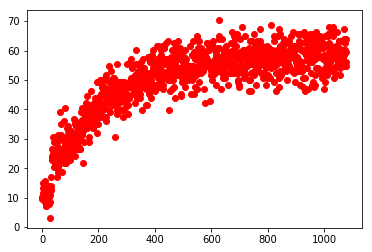

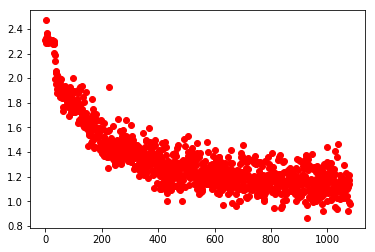

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

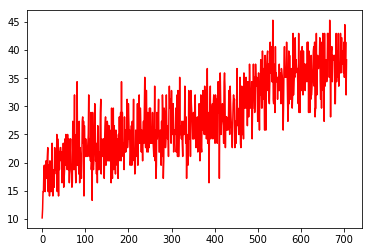

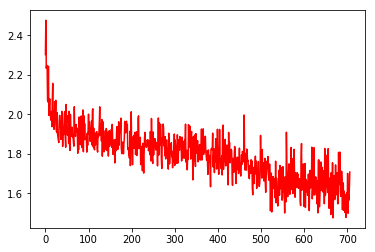

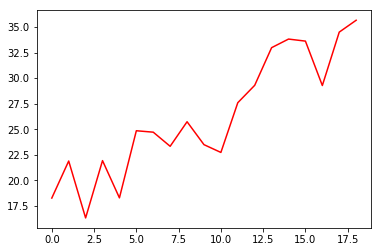

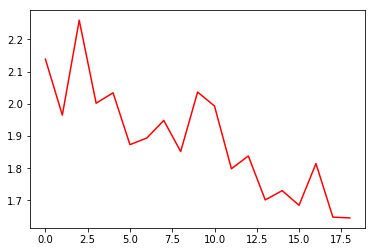

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()